In [498]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when
spark = SparkSession.builder.appName("SamsungStockClean").getOrCreate()
import pandas as pd
from pyampute.exploration.mcar_statistical_tests import MCARTest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import setuptools._distutils as distutils
import sys
sys.modules['distutils'] = distutils
from matplotlib.lines import Line2D
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost as xgb
import math
import warnings
warnings.filterwarnings('ignore')
import itertools    
import logging
logging.getLogger("prophet.plot").disabled = True
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
from datetime import datetime, timedelta

In [124]:
#Load data
ss = spark.read.csv("./Samsung Electronics Stock Historical Price.csv", header=True, inferSchema=True)
ss.printSchema()
ss.describe().show()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|summary|              Open|              High|              Low|             Close|         Adj Close|              Volume|
+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+
|  count|              1505|              1505|             1505|              1505|              1505|                1505|
|   mean|64154.617940199336| 64734.01993355482|63548.70431893688| 64108.90365448505| 59933.01363164452|1.6625267806644518E7|
| stddev|12269.830762688787|12321.091698838984|12176.81337181051|12227.346772831712|12894.680103072302|   87315

In [125]:
#Load KOSPI data
kospi = spark.read.csv("./KOSPI Data.csv", header=True, inferSchema=True)
kospi.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Vol.: string (nullable = true)
 |-- Change %: string (nullable = true)



In [126]:
ss.dtypes

[('Date', 'date'),
 ('Open', 'double'),
 ('High', 'double'),
 ('Low', 'double'),
 ('Close', 'double'),
 ('Adj Close', 'double'),
 ('Volume', 'int')]

In [127]:
# Count missing values in each column
missing = {col_name: ss.filter(col(col_name).isNull()).count() for col_name in ss.columns}
print(missing)
# Because the data of the stock price is updated every day, there is no missing value in the data.

{'Date': 0, 'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Adj Close': 0, 'Volume': 0}


In [128]:
# Check for duplicate rows
duplicates = ss.groupBy(ss.columns).count().filter(col("count") > 1)
print("Number of duplicate rows:", duplicates.count())
duplicates.show()

Number of duplicate rows: 0
+----+----+----+---+-----+---------+------+-----+
|Date|Open|High|Low|Close|Adj Close|Volume|count|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+



In [129]:
# Check if 'Open' or 'Close' is less than 'Low'
lower_than_low = ss.filter((col("Open") < col("Low")) | (col("Close") < col("Low")))
print("Số lần 'Open' hoặc 'Close' thấp hơn 'Low':", lower_than_low.count())
lower_than_low.show()
# Fix incorrect data: if 'Low' < 'Close', set 'Low' to 'Close'
ss_fixed = ss.withColumn("Low", when(col("Low") < col("Close"), col("Close")).otherwise(col("Low")))

ss_fixed.orderBy("Date").show(5)


Số lần 'Open' hoặc 'Close' thấp hơn 'Low': 1
+----------+-------+-------+-------+-------+-------------+--------+
|      Date|   Open|   High|    Low|  Close|    Adj Close|  Volume|
+----------+-------+-------+-------+-------+-------------+--------+
|2024-10-14|59500.0|61200.0|59400.0|59300.0|58898.3984375|20886249|
+----------+-------+-------+-------+-------+-------------+--------+

+----------+-------+-------+-------+-------+---------------+--------+
|      Date|   Open|   High|    Low|  Close|      Adj Close|  Volume|
+----------+-------+-------+-------+-------+---------------+--------+
|2019-01-02|39400.0|39400.0|38750.0|38750.0| 33061.84765625| 7847664|
|2019-01-03|38300.0|38550.0|37600.0|37600.0|32080.662109375|12471493|
|2019-01-04|37450.0|37600.0|37450.0|37450.0| 31952.66796875|14108958|
|2019-01-07|38000.0|38900.0|38750.0|38750.0| 33061.84765625|12748997|
|2019-01-08|38000.0|39200.0|38100.0|38100.0|32507.259765625|12756554|
+----------+-------+-------+-------+-------+----------

In [130]:
# Convert spark DataFrame to Pandas DataFrame
ss_pd = ss_fixed.toPandas()
kospi_pd = kospi.toPandas()

In [131]:
#Stop Spark session
spark.stop()

### **1. Data Analysis**

##### Candle chart of 200 days nearest


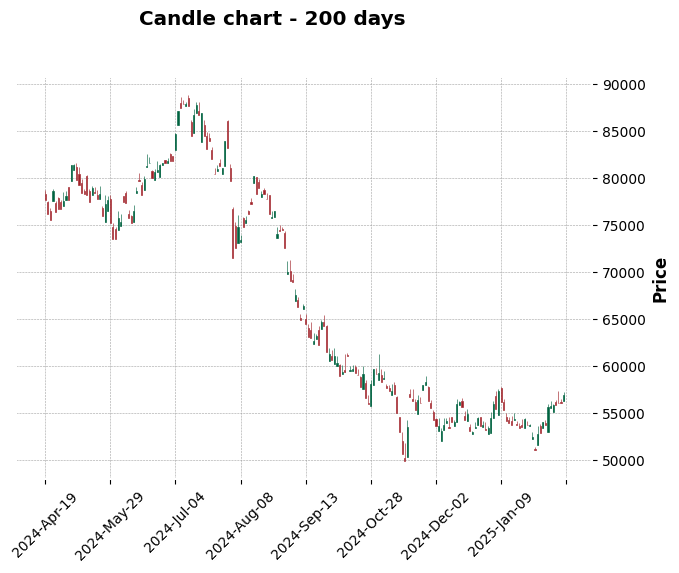

In [132]:
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_candle = ss_pd[['Date', 'Open', 'High', 'Low', 'Close']].copy()
ss_candle.set_index('Date', inplace=True)

mpf.plot(ss_candle[-200:], type='candle', style='charles', title='Candle chart - 200 days')


##### Samsung versus KOSPI cumulative daily return

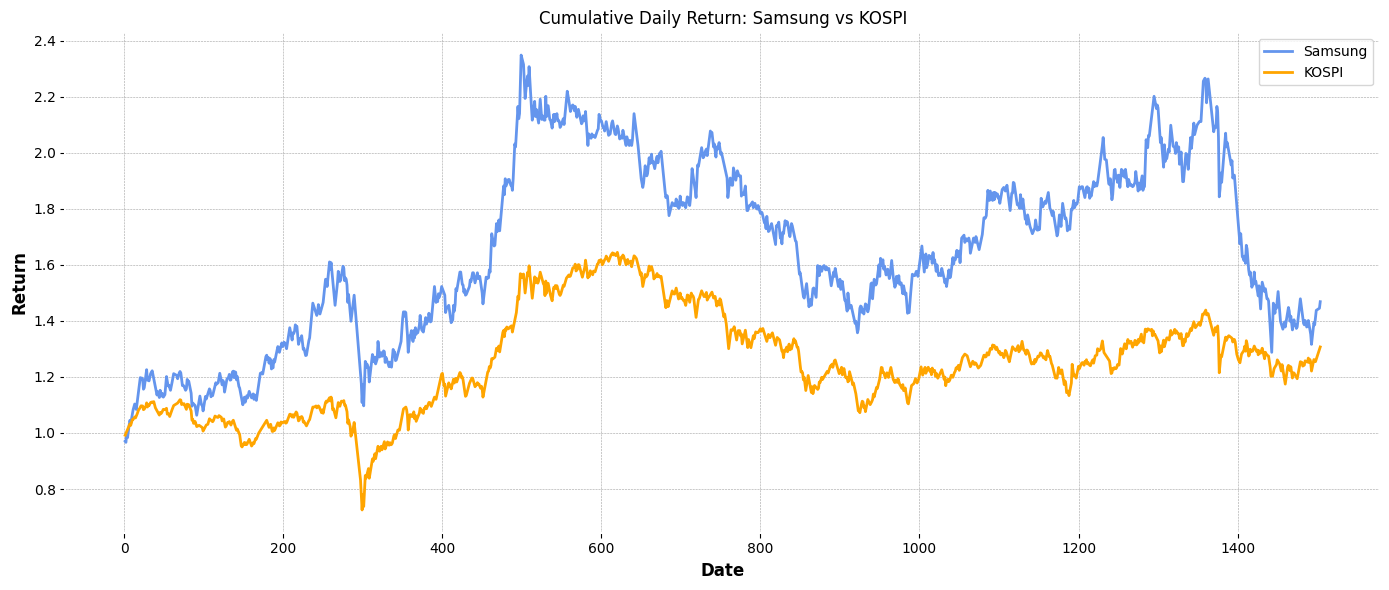

In [133]:
# Calculate daily returns 
ss_pd['Return'] = ss_pd['Close'].pct_change()
kospi_pd['Price'] = pd.to_numeric(kospi_pd['Price'].str.replace(',', ''), errors='coerce')
kospi_pd['Return'] = kospi_pd['Price'].pct_change()
# Merge two dataframes on Date index
returns = pd.merge(
    ss_pd[['Return']], 
    kospi_pd[['Return']], 
    left_index=True, 
    right_index=True, 
    suffixes=('_Samsung', '_KOSPI')
)
# Calculate the cumulative returns
cumulative_returns = (1 + returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns.index, cumulative_returns['Return_Samsung'], label='Samsung', color='cornflowerblue')
plt.plot(cumulative_returns.index, cumulative_returns['Return_KOSPI'], label='KOSPI', color='orange')
plt.title("Cumulative Daily Return: Samsung vs KOSPI")
plt.ylabel("Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Return Distribution

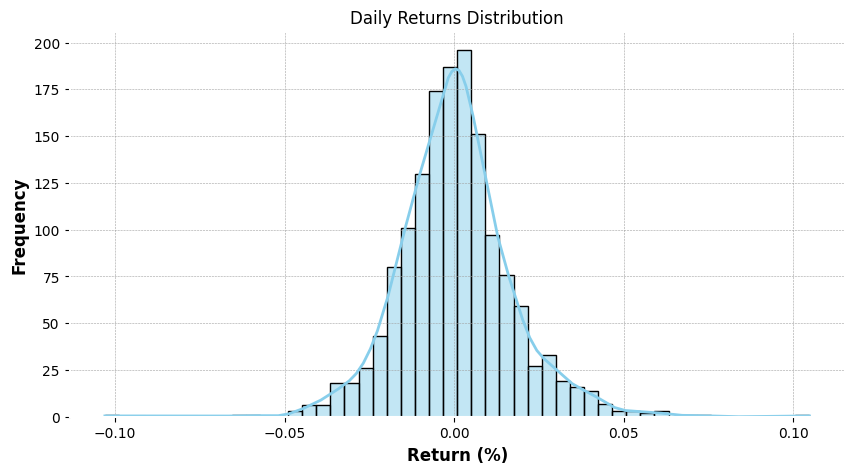

In [134]:
plt.figure(figsize=(10, 5))
sns.histplot(ss_pd['Return'].dropna(), bins=50, kde=True, color='skyblue')
plt.title('Daily Returns Distribution')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.show()

##### Trend Analysis

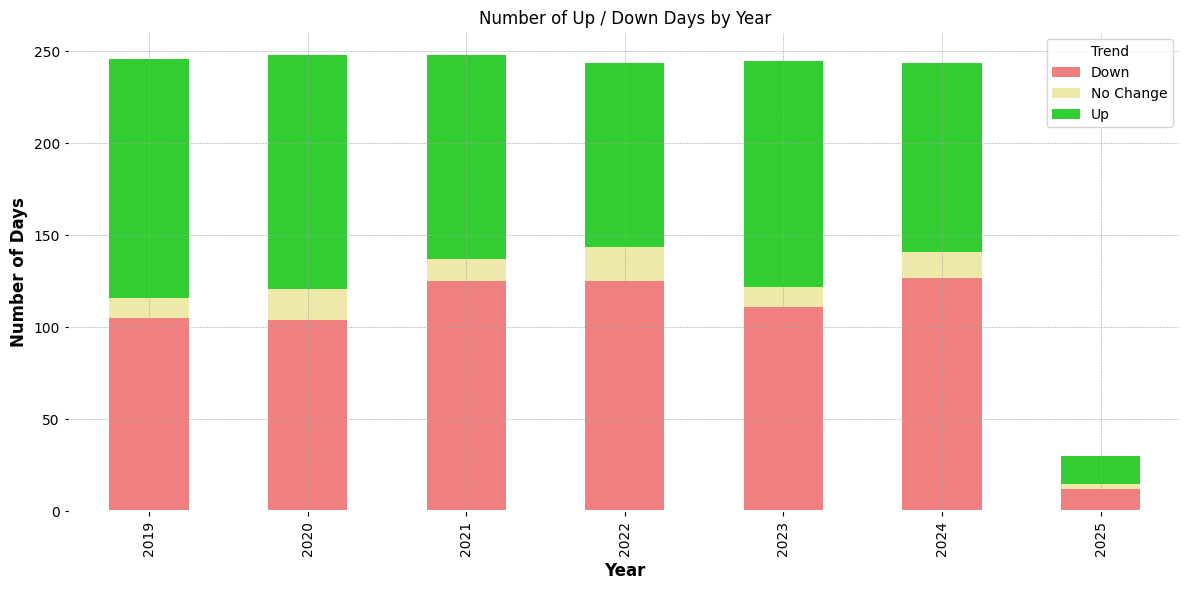

In [135]:
# Label the trend
ss_pd['Trend'] = np.where(ss_pd['Return'] > 0, 'Up', 
                       np.where(ss_pd['Return'] < 0, 'Down', 'No Change'))

ss_pd['Year'] = ss_pd['Date'].dt.year
trend_by_year = ss_pd.groupby(['Year', 'Trend']).size().unstack(fill_value=0)

colors = {
    'Up': 'limegreen',
    'Down': 'lightcoral',
    'No Change': 'palegoldenrod'
}
trend_by_year.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors[col] for col in trend_by_year.columns])
plt.title('Number of Up / Down Days by Year')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.legend(title='Trend')
plt.tight_layout()
plt.show()

##### Stock Price & Trading Volume with SMA (20/50)

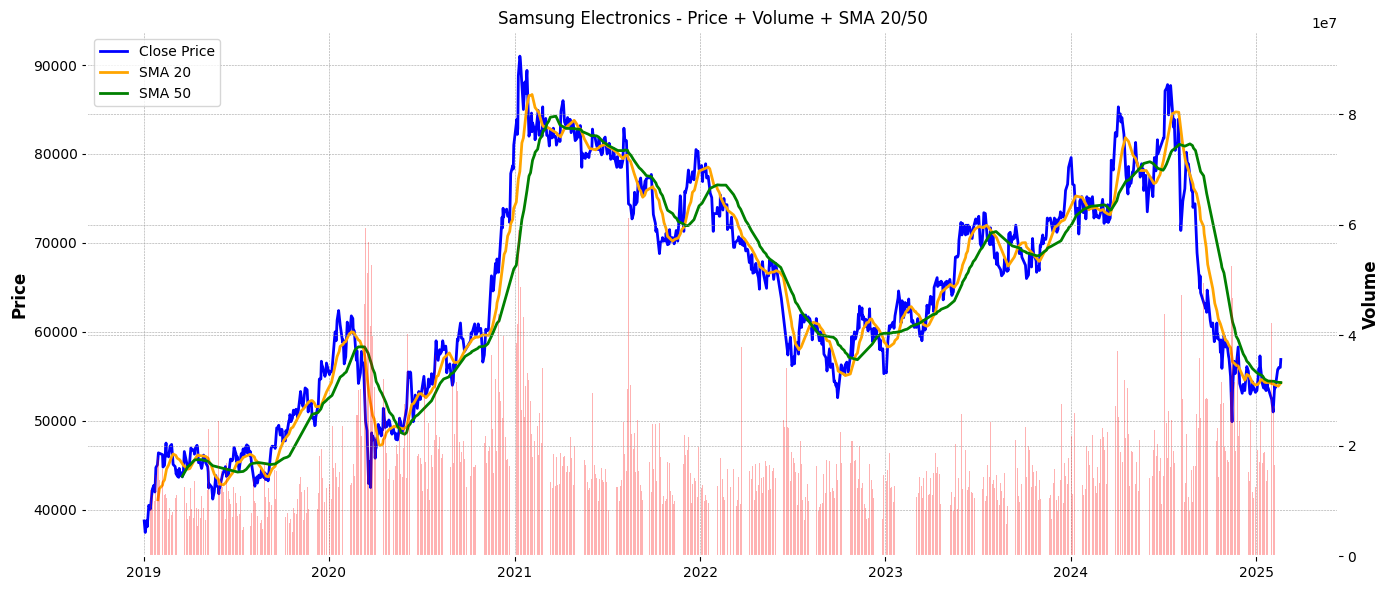

In [136]:
# Đọc dữ liệu
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd.sort_values('Date', inplace=True)

# Tính SMA 20 và SMA 50
ss_pd['SMA20'] = ss_pd['Close'].rolling(window=20).mean()
ss_pd['SMA50'] = ss_pd['Close'].rolling(window=50).mean()

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(ss_pd['Date'], ss_pd['Close'], label='Close Price', color='blue')
ax1.plot(ss_pd['Date'], ss_pd['SMA20'], label='SMA 20', color='orange')
ax1.plot(ss_pd['Date'], ss_pd['SMA50'], label='SMA 50', color='green')
ax1.set_ylabel('Price')
ax1.tick_params(axis='y')

# Vẽ biểu đồ Volume
ax2 = ax1.twinx()
ax2.bar(ss_pd['Date'], ss_pd['Volume'], color='red', alpha=0.3)
ax2.set_ylabel('Volume')
ax2.tick_params(axis='y')

# Định dạng thời gian
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Samsung Electronics - Price + Volume + SMA 20/50')
ax1.legend(loc='upper left')
fig.tight_layout()
plt.show()


##### Trading Volume with VMA (20/50)

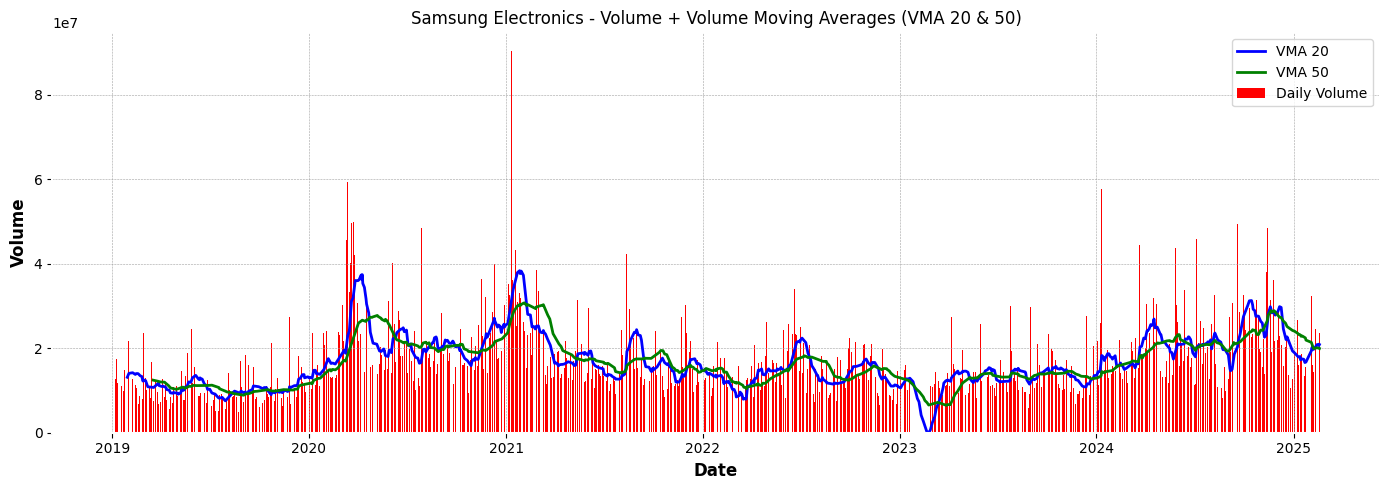

In [137]:
# Đọc dữ liệu
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd.sort_values('Date', inplace=True)

# Tính SMA cho Volume (VMA)
ss_pd['VMA20'] = ss_pd['Volume'].rolling(window=20).mean()
ss_pd['VMA50'] = ss_pd['Volume'].rolling(window=50).mean()

# Vẽ biểu đồ Volume + VMA
plt.figure(figsize=(14, 5))
plt.bar(ss_pd['Date'], ss_pd['Volume'], color='red', label='Daily Volume')
plt.plot(ss_pd['Date'], ss_pd['VMA20'], color='blue', label='VMA 20')
plt.plot(ss_pd['Date'], ss_pd['VMA50'], color='green', label='VMA 50')

plt.title("Samsung Electronics - Volume + Volume Moving Averages (VMA 20 & 50)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)

# Định dạng trục thời gian
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

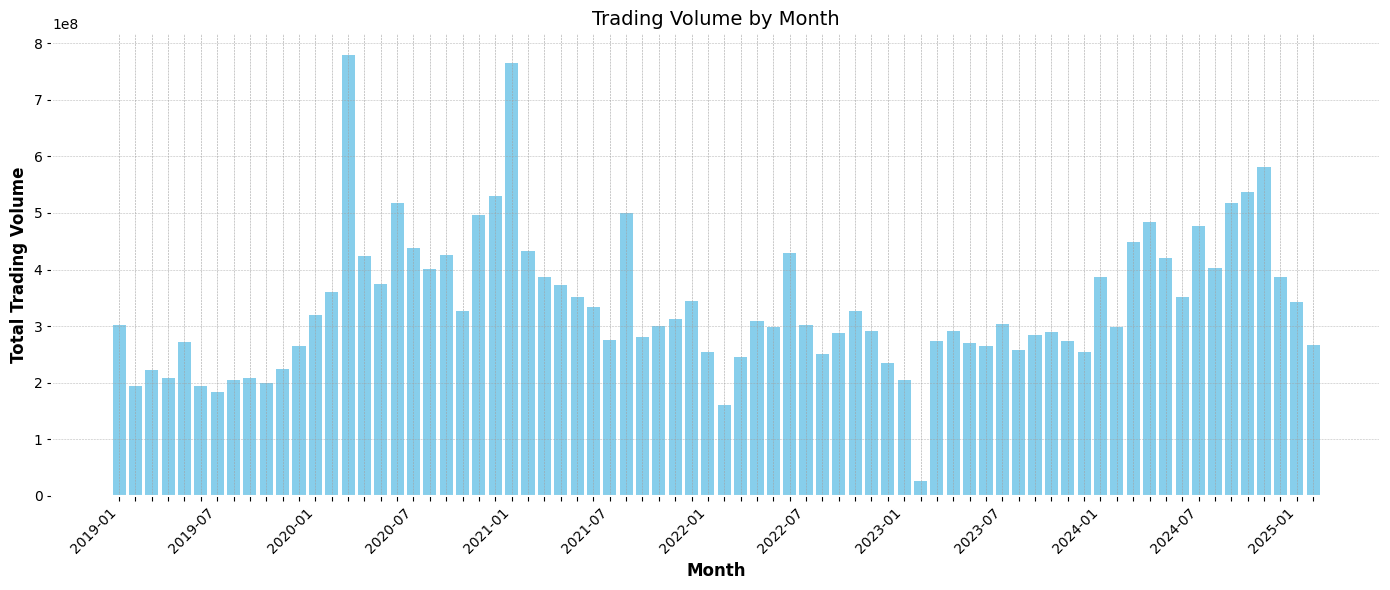

In [138]:
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])

ss_pd['Year'] = ss_pd['Date'].dt.year
ss_pd['Month'] = ss_pd['Date'].dt.month

monthly_volume = ss_pd.groupby(['Year', 'Month'])['Volume'].sum().reset_index()

monthly_volume['Year-Month'] = monthly_volume['Year'].astype(str) + "-" + monthly_volume['Month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 6))
plt.bar(monthly_volume['Year-Month'], monthly_volume['Volume'], color='skyblue')

xticks = monthly_volume['Year-Month']
xtick_labels = [label if i % 6 == 0 else '' for i, label in enumerate(xticks)]
plt.xticks(ticks=range(len(xticks)), labels=xtick_labels, rotation=45, ha='right')

plt.title('Trading Volume by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Trading Volume', fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


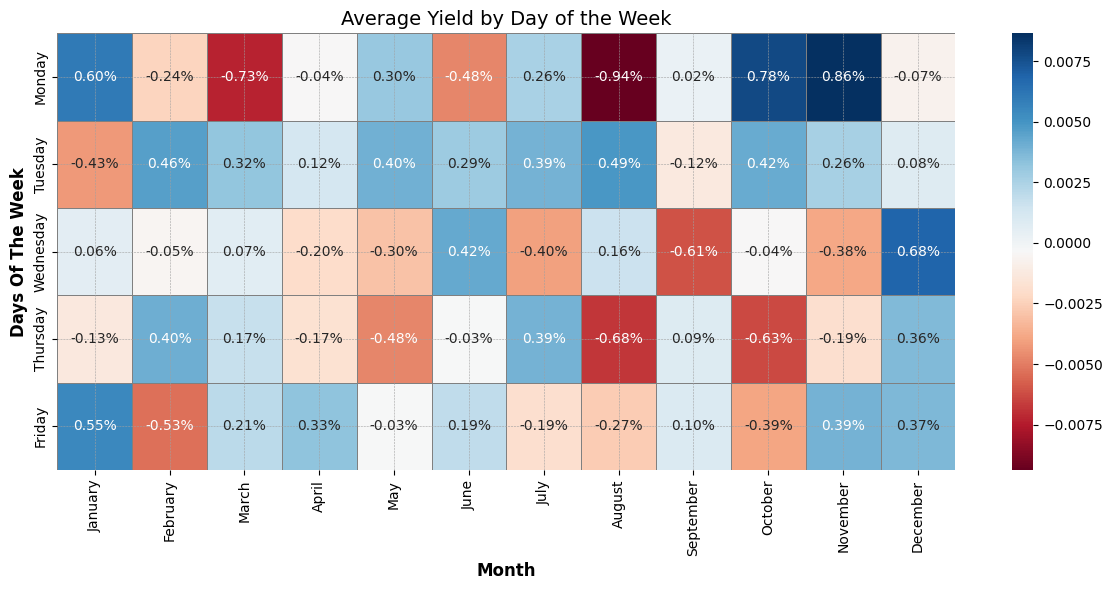

In [139]:

ss_pd = ss_pd.sort_values('Date')
ss_pd['Return'] = ss_pd['Close'].pct_change()
ss_pd['Weekday'] = ss_pd['Date'].dt.day_name()
ss_pd['Month'] = ss_pd['Date'].dt.month_name()

pivot_table = ss_pd.pivot_table(index='Weekday', columns='Month', values='Return', aggfunc='mean')

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

pivot_table = pivot_table.reindex(index=weekday_order, columns=month_order)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='RdBu', annot=True, fmt=".2%", linewidths=0.5, linecolor='gray')
plt.title('Average Yield by Day of the Week', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Days Of The Week')
plt.tight_layout()
plt.show()


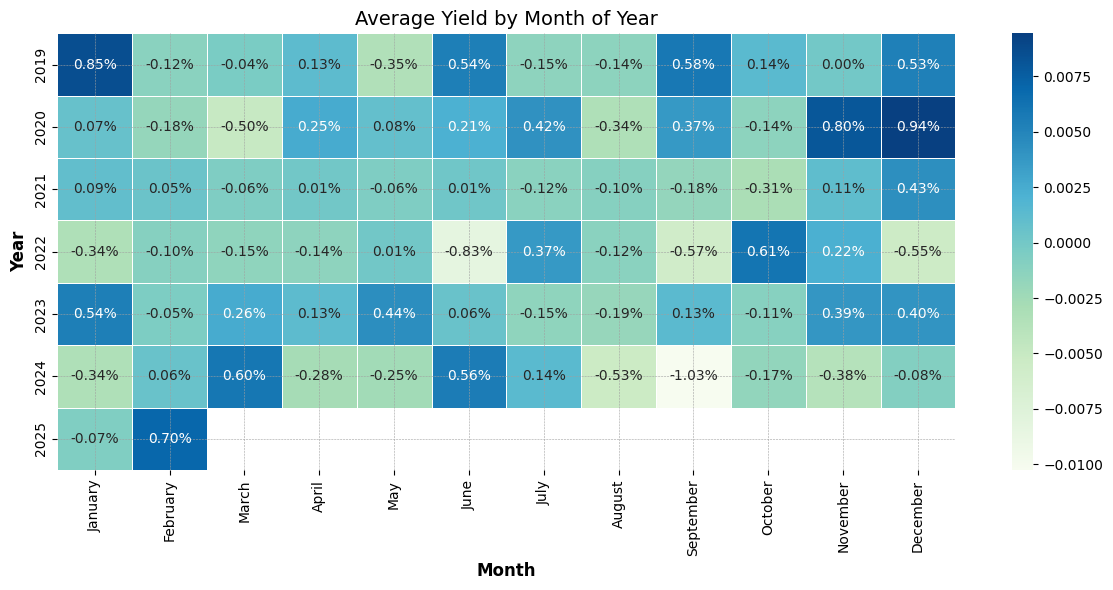

In [140]:
ss_pd = pd.read_csv("Samsung Electronics Stock Historical Price.csv")
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd = ss_pd.sort_values('Date')

ss_pd['Return'] = ss_pd['Close'].pct_change()

ss_pd['Year'] = ss_pd['Date'].dt.year
ss_pd['Month'] = ss_pd['Date'].dt.month_name()

pivot = ss_pd.pivot_table(index='Year', columns='Month', values='Return', aggfunc='mean')

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pivot = pivot[month_order]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='GnBu', annot=True, fmt=".2%", linewidths=0.5)
plt.title('Average Yield by Month of Year', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


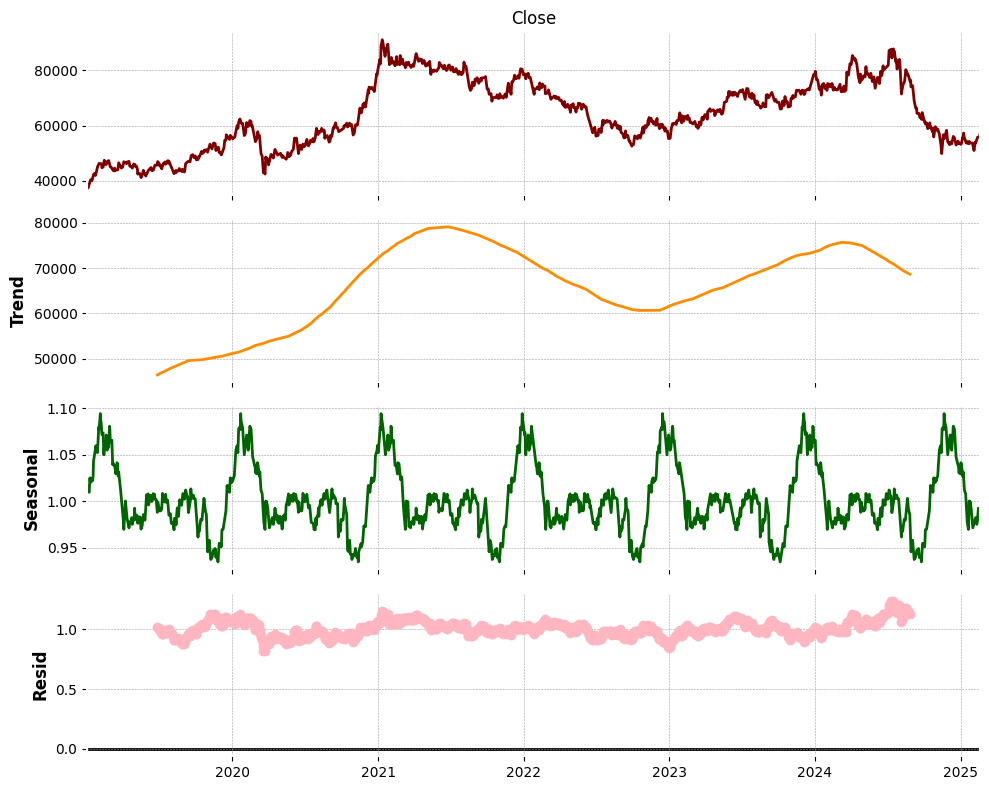

In [141]:
file_path = "Samsung Electronics Stock Historical Price.csv"
ss_pd = pd.read_csv(file_path)
ss_pd['Date'] = pd.to_datetime(ss_pd['Date'])
ss_pd.sort_values('Date', inplace=True)
ss_pd.set_index('Date', inplace=True)

close_series = ss_pd['Close'].asfreq('B').ffill()

decomposition = seasonal_decompose(close_series, model='multiplicative', period=252)

fig = decomposition.plot()
fig.set_size_inches(10, 8)

axes = fig.axes

axes[0].lines[0].set_color('maroon')      
axes[1].lines[0].set_color('darkorange')       
axes[2].lines[0].set_color('darkgreen')     
axes[3].lines[0].set_color('lightpink')       

plt.tight_layout()

### **2.TECHNICAL ANALYSIS**



Samsung Electronics - Market Sentiment Analysis (as of 2025-02-18)
Current Price: 56,900 KRW
1-Month Momentum: 5.6%
3-Month Momentum: 7.4%
6-Month Momentum: -21.5%

Current Market Sentiment: Greed


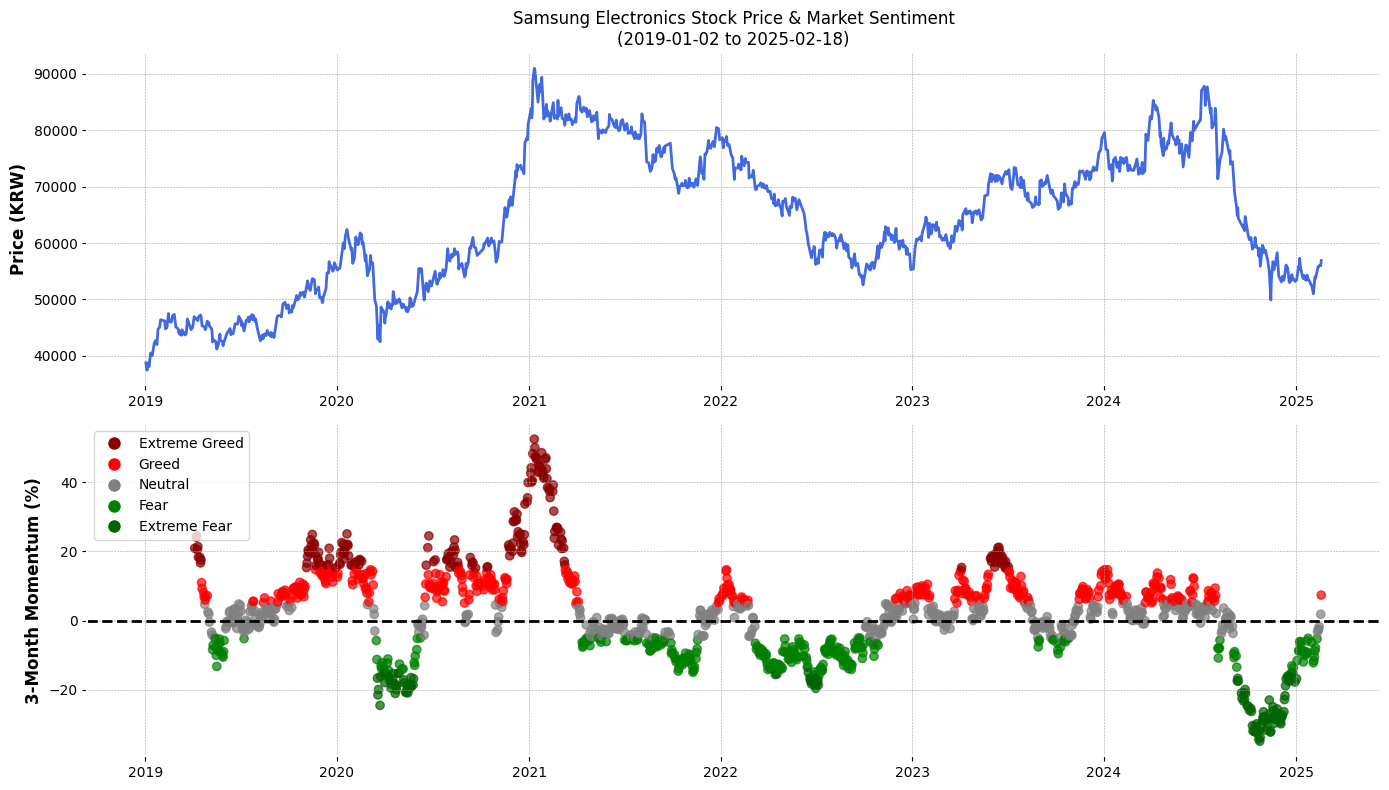

In [142]:
# Calculate momentum indicators
ss_pd['1M_Return'] = ss_pd['Close'].pct_change(21)  # 1-month momentum
ss_pd['3M_Return'] = ss_pd['Close'].pct_change(63)  # 3-month momentum
ss_pd['6M_Return'] = ss_pd['Close'].pct_change(126) # 6-month momentum

# Create sentiment classification
def classify_sentiment(row):
    if row['3M_Return'] > 0.15:
        return 'Extreme Greed'
    elif row['3M_Return'] > 0.05:
        return 'Greed'
    elif row['3M_Return'] < -0.15:
        return 'Extreme Fear'
    elif row['3M_Return'] < -0.05:
        return 'Fear'
    else:
        return 'Neutral'

ss_pd['Sentiment'] = ss_pd.apply(classify_sentiment, axis=1)

# Get latest data
latest = ss_pd.iloc[-1]
latest_date = str(latest.name.date())
latest_close = latest['Close']

# Print analysis
print(f"\nSamsung Electronics - Market Sentiment Analysis (as of {latest_date})")
print("="*60)
print(f"Current Price: {latest_close:,.0f} KRW")
print(f"1-Month Momentum: {latest['1M_Return']*100:.1f}%")
print(f"3-Month Momentum: {latest['3M_Return']*100:.1f}%")
print(f"6-Month Momentum: {latest['6M_Return']*100:.1f}%")
print(f"\nCurrent Market Sentiment: {latest['Sentiment']}")

# Visualization
plt.figure(figsize=(14, 8))

# Price chart
ax1 = plt.subplot(2, 1, 1)
plt.plot(ss_pd.index, ss_pd['Close'], color='royalblue', linewidth=2)
plt.title(f'Samsung Electronics Stock Price & Market Sentiment\n({ss_pd.index[0].date()} to {ss_pd.index[-1].date()})')
plt.ylabel('Price (KRW)')
plt.grid(True)

# Momentum chart
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
colors = {'Extreme Greed':'darkred', 'Greed':'red', 'Neutral':'gray', 'Fear':'green', 'Extreme Fear':'darkgreen'}
plt.scatter(ss_pd.index, ss_pd['3M_Return']*100, c=ss_pd['Sentiment'].map(colors), alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('3-Month Momentum (%)')
plt.grid(True)

# Formatting
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()


# Add legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Extreme Greed',
                   markerfacecolor='darkred', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Greed',
                   markerfacecolor='red', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Neutral',
                   markerfacecolor='gray', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Fear',
                   markerfacecolor='green', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Extreme Fear',
                   markerfacecolor='darkgreen', markersize=10)]
ax2.legend(handles=legend_elements, loc='upper left')
plt.show()

##### Volume analysis

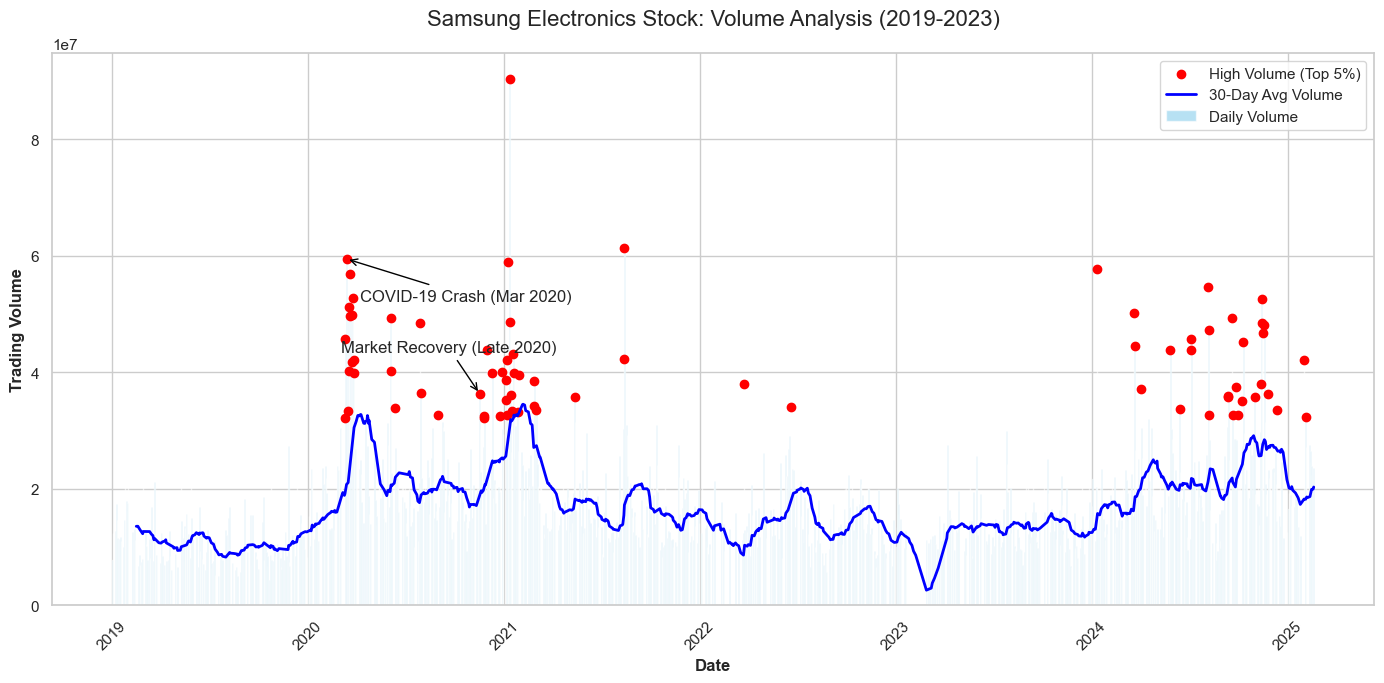

In [143]:
sns.set(style="whitegrid")
# Create the plot
plt.figure(figsize=(14, 7))

# Plot the trading volume
plt.bar(ss_pd.index, ss_pd['Volume'], color='skyblue', alpha=0.6, label='Daily Volume')

# Highlight extreme volume spikes (top 5%)
high_volume_threshold = ss_pd['Volume'].quantile(0.95)
high_volume_days = ss_pd[ss_pd['Volume'] >= high_volume_threshold]
plt.scatter(high_volume_days.index, high_volume_days['Volume'], color='red', label='High Volume (Top 5%)')

# Add moving average for smoother trend (30-day rolling average)
rolling_volume = ss_pd['Volume'].rolling(window=30).mean()
plt.plot(ss_pd.index, rolling_volume, color='blue', linewidth=2, label='30-Day Avg Volume')

# Annotations for notable events
plt.annotate('COVID-19 Crash (Mar 2020)',
             xy=(pd.to_datetime('2020-03-13'), ss_pd.loc['2020-03-13', 'Volume']),
             xytext=(10, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.annotate('Market Recovery (Late 2020)',
             xy=(pd.to_datetime('2020-11-16'), ss_pd.loc['2020-11-16', 'Volume']),
             xytext=(-100, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'))

# Labels and title
plt.title('Samsung Electronics Stock: Volume Analysis (2019-2023)', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trading Volume', fontsize=12)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

##### MACD & Trade Signal

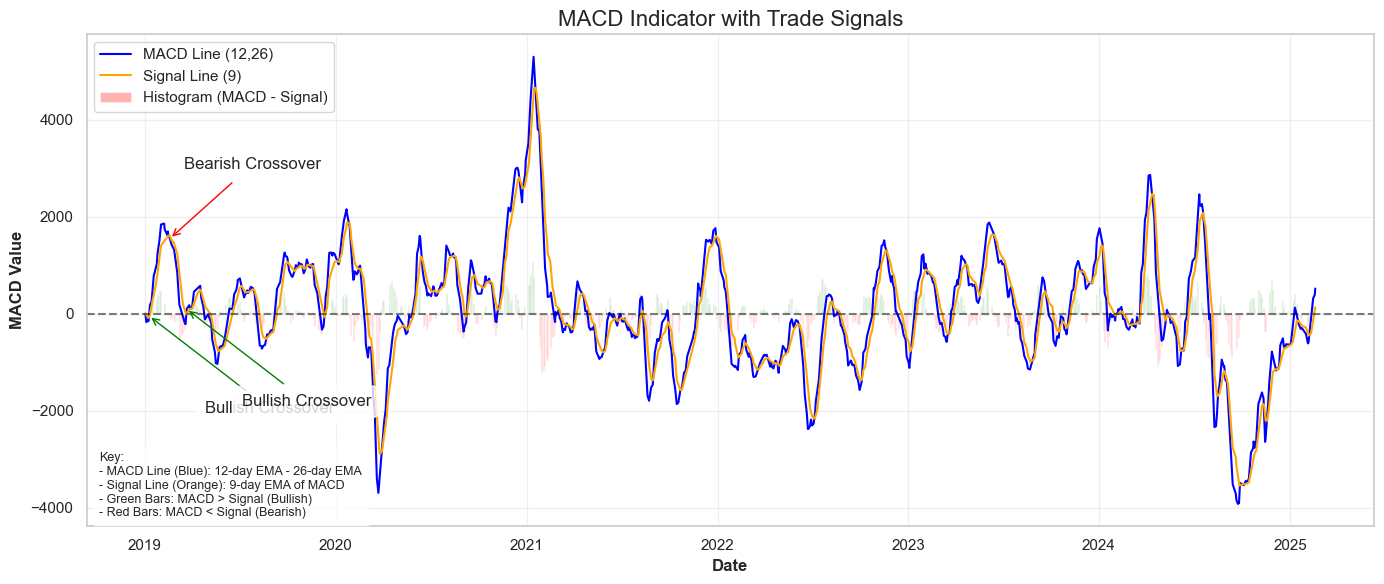

In [144]:
def calculate_macd(ss_pd, fast=12, slow=26, signal=9):
    ss_pd['EMA_Fast'] = ss_pd['Close'].ewm(span=fast, adjust=False).mean()
    ss_pd['EMA_Slow'] = ss_pd['Close'].ewm(span=slow, adjust=False).mean()
    ss_pd['MACD'] = ss_pd['EMA_Fast'] - ss_pd['EMA_Slow']
    ss_pd['Signal_Line'] = ss_pd['MACD'].ewm(span=signal, adjust=False).mean()
    ss_pd['MACD_Histogram'] = ss_pd['MACD'] - ss_pd['Signal_Line']
    return ss_pd

ss_pd = calculate_macd(ss_pd)

# --- Plot MACD with Annotations ---
plt.figure(figsize=(14, 6))


# 1. MACD and Signal Line
plt.plot(ss_pd.index, ss_pd['MACD'], label='MACD Line (12,26)', color='blue', linewidth=1.5)
plt.plot(ss_pd.index, ss_pd['Signal_Line'], label='Signal Line (9)', color='orange', linewidth=1.5)

# 2. Histogram (Green/Red Bars)
plt.bar(ss_pd.index, ss_pd['MACD_Histogram'],
        color=np.where(ss_pd['MACD_Histogram'] > 0, 'green', 'red'),
        alpha=0.3, label='Histogram (MACD - Signal)')

plt.axhline(0, color='black', linestyle='--', alpha=0.5)  # Zero line

# --- Annotations ---
# Find actual crossovers in the data
crossovers = ss_pd[ss_pd['MACD_Histogram'].shift(1) * ss_pd['MACD_Histogram'] < 0]

# Label the first few crossovers (you can adjust this)
for i, date in enumerate(crossovers.index[:3]):  # Show first 3 crossovers
    if ss_pd.loc[date, 'MACD_Histogram'] > 0:  # Bullish crossover
        plt.annotate('Bullish Crossover',
                    xy=(date, ss_pd.loc[date, 'MACD']),
                    xytext=(40, -70), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='green'),
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
    else:  # Bearish crossover
        plt.annotate('Bearish Crossover',
                    xy=(date, ss_pd.loc[date, 'MACD']),
                    xytext=(10, 50), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red'),
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
# General Explanations
plt.text(
    0.01, 0.02,
    'Key:\n'
    '- MACD Line (Blue): 12-day EMA - 26-day EMA\n'
    '- Signal Line (Orange): 9-day EMA of MACD\n'
    '- Green Bars: MACD > Signal (Bullish)\n'
    '- Red Bars: MACD < Signal (Bearish)',
    transform=plt.gca().transAxes,  # Fixed typo here (transAxex → transAxes)
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.8)
)
plt.title('MACD Indicator with Trade Signals', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('MACD Value', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


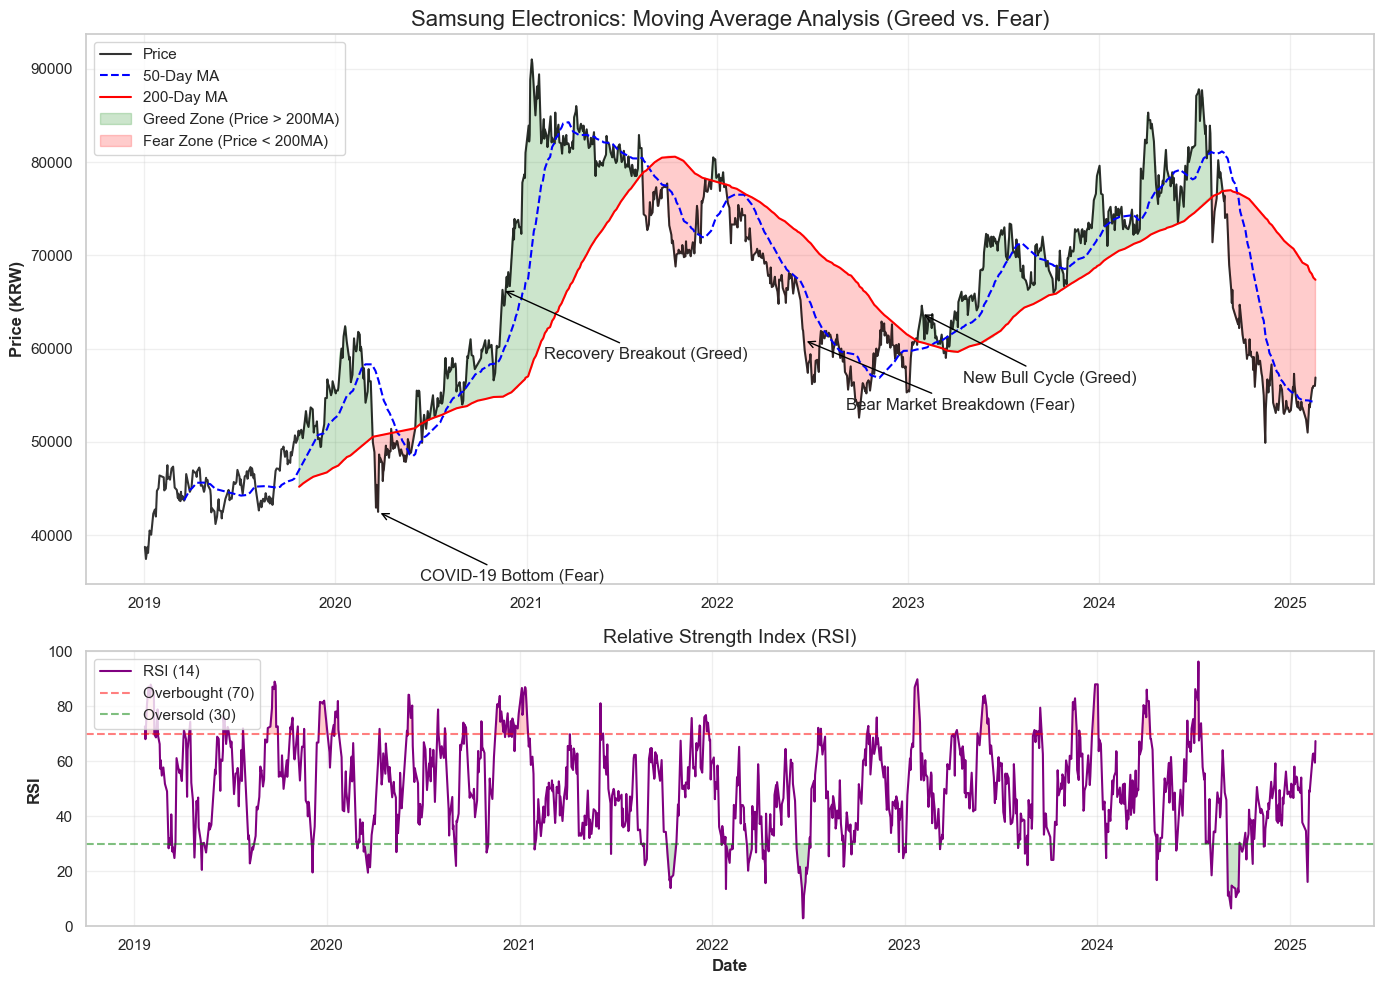

In [145]:
# --- Calculate Moving Averages and Signals (Existing Code) ---
ss_pd['MA_50'] = ss_pd['Close'].rolling(window=50).mean()
ss_pd['MA_200'] = ss_pd['Close'].rolling(window=200).mean()
ss_pd['Signal'] = 0  
ss_pd.loc[ss_pd['Close'] > ss_pd['MA_200'], 'Signal'] = 1  # Greed
ss_pd.loc[ss_pd['Close'] < ss_pd['MA_200'], 'Signal'] = -1  # Fear

# --- Calculate RSI (New Code) ---
def calculate_rsi(ss_pd, window=14):
    delta = ss_pd['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

ss_pd['RSI'] = calculate_rsi(ss_pd)  # Add RSI column

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# 1. Price and Moving Averages (Top Subplot)
ax1.plot(ss_pd.index, ss_pd['Close'], label='Price', color='black', alpha=0.8)
ax1.plot(ss_pd.index, ss_pd['MA_50'], label='50-Day MA', color='blue', linestyle='--')
ax1.plot(ss_pd.index, ss_pd['MA_200'], label='200-Day MA', color='red', linestyle='-')

# Highlight greed/fear zones
ax1.fill_between(ss_pd.index, 
                 ss_pd['Close'].where(ss_pd['Signal'] == 1), 
                 ss_pd['MA_200'].where(ss_pd['Signal'] == 1),
                 color='green', alpha=0.2, label='Greed Zone (Price > 200MA)')
ax1.fill_between(ss_pd.index, 
                 ss_pd['Close'].where(ss_pd['Signal'] == -1), 
                 ss_pd['MA_200'].where(ss_pd['Signal'] == -1),
                 color='red', alpha=0.2, label='Fear Zone (Price < 200MA)')

# Annotate events (adjusted xytext for spacing)
events = {
    '2020-03-23': 'COVID-19 Bottom (Fear)',
    '2020-11-16': 'Recovery Breakout (Greed)',
    '2022-06-16': 'Bear Market Breakdown (Fear)',
    '2023-01-26': 'New Bull Cycle (Greed)'
}
for date, label in events.items():
    if pd.to_datetime(date) in ss_pd.index:
        price = ss_pd.loc[pd.to_datetime(date), 'Close']
        ax1.annotate(label, xy=(pd.to_datetime(date), price),
                     xytext=(30, -50), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->', color='black'))

ax1.set_title('Samsung Electronics: Moving Average Analysis (Greed vs. Fear)', fontsize=16)
ax1.set_ylabel('Price (KRW)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. RSI Chart (Bottom Subplot)
ax2.plot(ss_pd.index, ss_pd['RSI'], label='RSI (14)', color='purple', linewidth=1.5)
ax2.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax2.axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
ax2.fill_between(ss_pd.index, 70, ss_pd['RSI'].where(ss_pd['RSI'] >= 70), 
                 color='red', alpha=0.2)
ax2.fill_between(ss_pd.index, 30, ss_pd['RSI'].where(ss_pd['RSI'] <= 30), 
                 color='green', alpha=0.2)

ax2.set_title('Relative Strength Index (RSI)', fontsize=14)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('RSI', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)  # RSI ranges from 0 to 100

plt.tight_layout()
plt.show()

# **4. FUTURE FORCASTING**

## **4.1. Rolling Mean & Standard Deviation:**

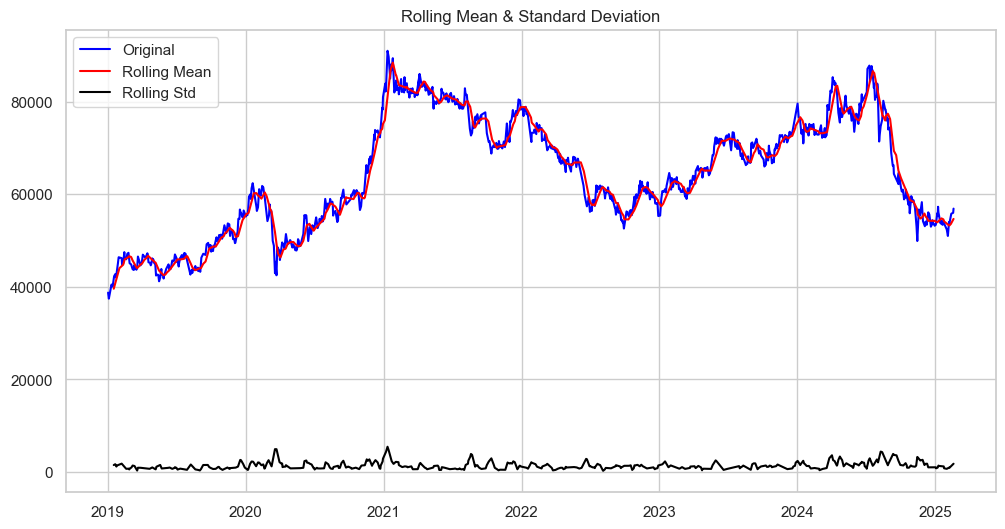

In [147]:
def test_stationarity(time_series):
    # Calculate rolling statistics
    rolling_mean = ss_pd['Close'].rolling(window=12).mean()
    rolling_std = ss_pd['Close'].rolling(window=12).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(ss_pd['Close'], color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)

test_stationarity(ss_pd['Close'])

## **4.2. XGBoost model:**

The stock's daily closing price:

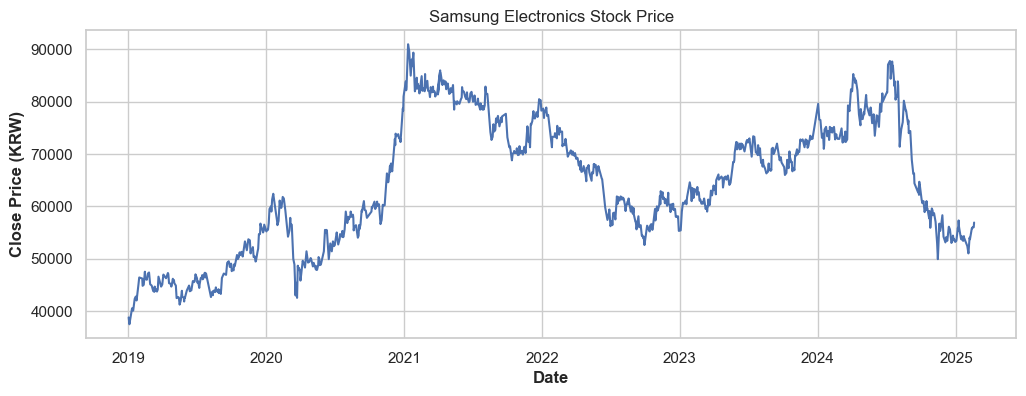

In [160]:
plt.figure(figsize=(12, 4))
plt.plot(ss_pd['Close'])
plt.title('Samsung Electronics Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.grid(True)
plt.show()

In [426]:
df_simple = ss_pd.reset_index()[['Date', 'Close']].copy()

# Display the first few rows
print("Simple dataframe with Date and Close columns:")
print(df_simple.head())

Simple dataframe with Date and Close columns:
        Date    Close
0 2019-01-02  38750.0
1 2019-01-03  37600.0
2 2019-01-04  37450.0
3 2019-01-07  38750.0
4 2019-01-08  38100.0


In [429]:
df_simple['Date'] = pd.to_datetime(df_simple['Date'])
df_simple = df_simple.sort_values("Date").reset_index(drop=True)
df_simple = df_simple.rename(columns={"Date": "ds", "Close": "y"})

In [430]:
# Create lag features
for lag in range(1, 8):
    df_simple[f'lag_{lag}'] = df_simple['y'].shift(lag)

In [434]:
# Create lag features
for lag in range(1, 8):
    df_simple[f'lag_{lag}'] = df_simple['y'].shift(lag)

df_simple.dropna(inplace=True)

# Features and target
X = df_simple[[f'lag_{i}' for i in range(1, 8)]]
y = df_simple['y']

# Train/test split
train_size = int(len(df_simple) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train model
model = XGBRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [435]:
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


MAE: 1147.04, RMSE: 1537.06, MAPE: 1.65%


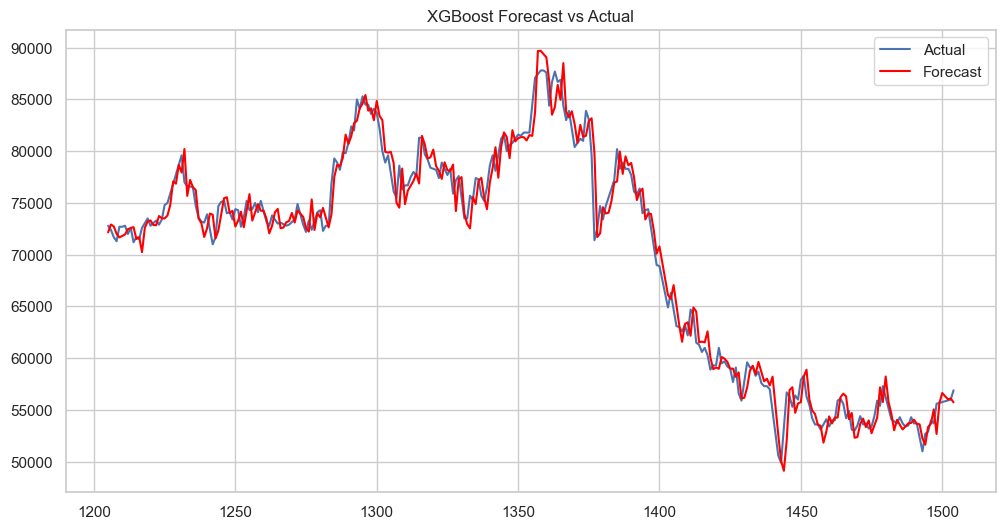

In [436]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Forecast', color='red')
plt.legend()
plt.title("XGBoost Forecast vs Actual")
plt.grid(True)
plt.show()

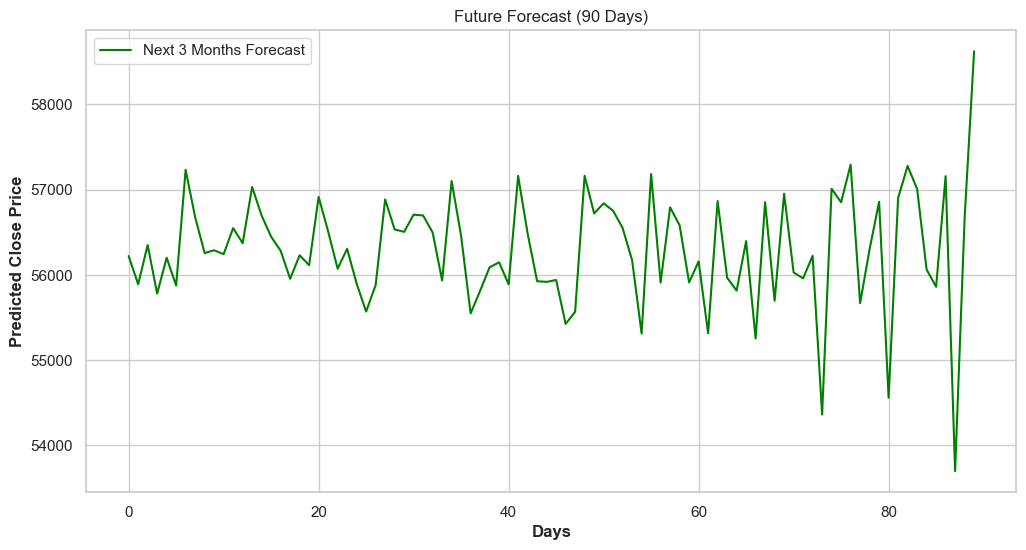

In [453]:
# Forecast next 3 months (assume 90 business days)
future = df_simple.iloc[-7:][['y']].values.flatten().tolist()
forecast = []

for _ in range(90):
    X_next = np.array(future[-7:]).reshape(1, -1)
    next_pred = model.predict(X_next)[0]
    forecast.append(next_pred)
    future.append(next_pred)

# Plot 3-month forecast
plt.figure(figsize=(12,6))
plt.plot(range(90), forecast, label="Next 3 Months Forecast", color='green')
plt.title("Future Forecast (90 Days)")
plt.xlabel("Days")
plt.ylabel("Predicted Close Price")
plt.grid(True)
plt.legend()


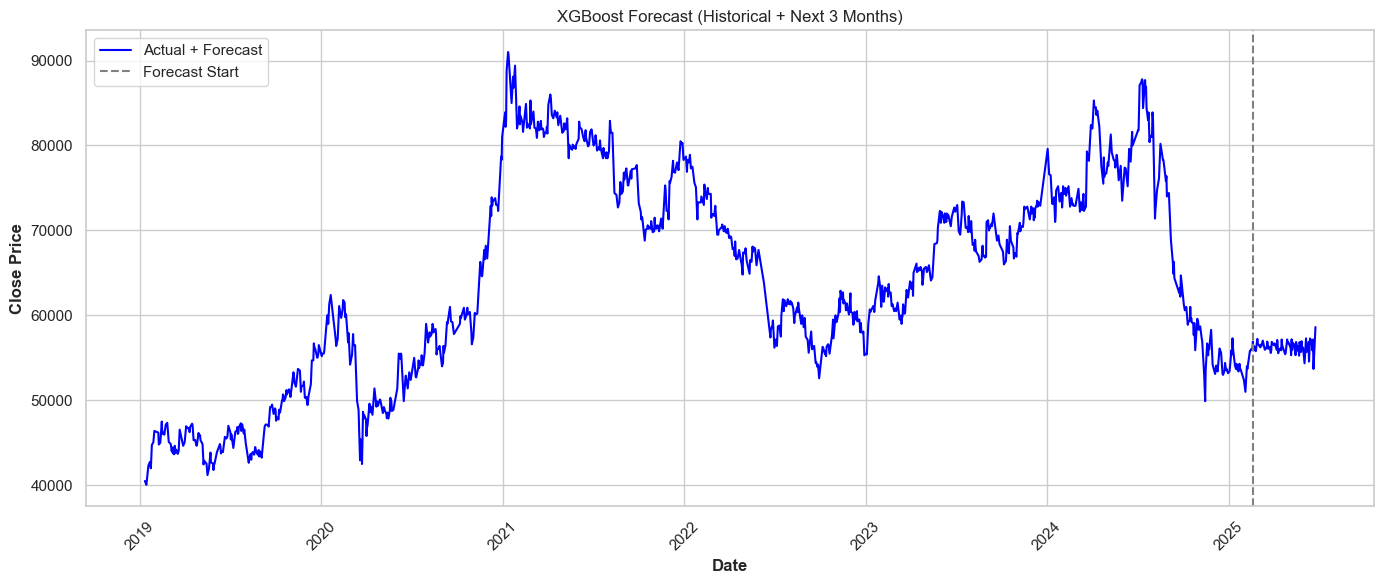

In [454]:
# Tạo mảng ngày cho forecast
last_date = df_simple['ds'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='B')

  # B = business days

# Gộp dữ liệu cũ và forecast thành một DataFrame duy nhất
historical_df = df_simple[['ds', 'y']].copy()
forecast_df = pd.DataFrame({
    'ds': forecast_dates[:len(forecast)],
    'y': forecast
})

combined_df = pd.concat([historical_df, forecast_df]).reset_index(drop=True)

# Vẽ biểu đồ kết hợp
plt.figure(figsize=(14, 6))
plt.plot(combined_df['ds'], combined_df['y'], label='Actual + Forecast', color='blue')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("XGBoost Forecast (Historical + Next 3 Months)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


-----------------

## **4.2. XGBoost Model**

In [475]:
df_xg = pd.read_csv('Samsung Electronics Stock Historical Price.csv')

# Use closing price as our target
data_xg = df_xg[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

test_size = int(len(df_xg) * 0.2)  # 20% as test set
train = data_xg[:-test_size]
test = data_xg[-test_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 1204, Test size: 301


In [478]:
# Feature engineering for XGBoost
def create_features(df_xg):
    # Convert ds column to datetime
    df_xg['ds'] = pd.to_datetime(df_xg['ds'])
    
    # Extract datetime features
    df_xg['dayofweek'] = df_xg['ds'].dt.dayofweek
    df_xg['quarter'] = df_xg['ds'].dt.quarter
    df_xg['month'] = df_xg['ds'].dt.month
    df_xg['year'] = df_xg['ds'].dt.year
    df_xg['dayofyear'] = df_xg['ds'].dt.dayofyear
    
    # Create lag features
    df_xg['lag1'] = df_xg['y'].shift(1)
    df_xg['lag7'] = df_xg['y'].shift(7)
    df_xg['lag30'] = df_xg['y'].shift(30)
    return df_xg

train_feat = create_features(train)
test_feat = create_features(test)

# Drop rows with NA (from lag features)
train_feat = train_feat.dropna()

# Split into X and y
X_train = train_feat.drop(['ds', 'y'], axis=1)
y_train = train_feat['y']
X_test = test_feat.drop(['ds', 'y'], axis=1)
y_test = test_feat['y']

# Scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost model
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=10,
    random_state=42
)

xgb_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# Predict
xgb_pred = xgb_model.predict(X_test_scaled)

# Calculate RMSE
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

XGBoost RMSE: 1831.43


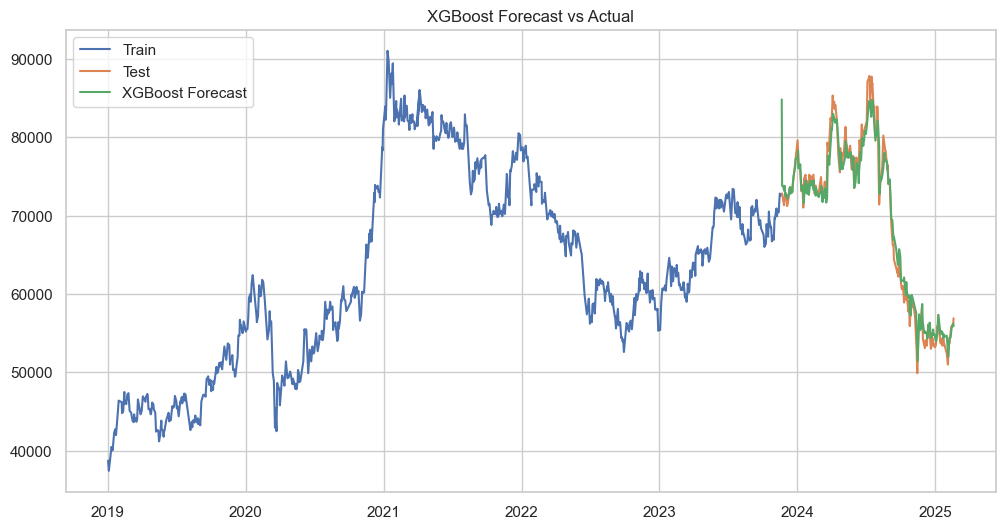

In [479]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], xgb_pred, label='XGBoost Forecast')
plt.legend()
plt.title('XGBoost Forecast vs Actual')
plt.show()

In [482]:
full_feat = create_features(data_xg)
full_feat = full_feat.dropna()
X_full = full_feat.drop(['ds', 'y'], axis=1)
y_full = full_feat['y']

In [483]:
# Scale
X_full_scaled = scaler.fit_transform(X_full)

# Train final model
final_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
final_model.fit(X_full_scaled, y_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [491]:
# Create future dates
last_date = data_xg['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')

# Create future features
future_df = pd.DataFrame({'ds': future_dates})
future_df['y'] = np.nan  # Placeholder

# Add features
future_feat = create_features(future_df)

# Fill lag features with most recent values from data_xg
for i in range(1, 31):
    if f'lag{i}' in future_feat.columns:
        # Fill each row with the appropriate lagged value
        for j in range(len(future_feat)):
            if j < i:
                # For initial rows where we don't have enough history, use the last available value
                future_feat.iloc[j, future_feat.columns.get_loc(f'lag{i}')] = data_xg['y'].iloc[-i]
            else:
                # For later rows, use the predicted values
                future_feat.iloc[j, future_feat.columns.get_loc(f'lag{i}')] = future_feat['y'].iloc[j-i]

# Ensure all required features are present and handle any remaining NaN values
future_feat = future_feat.fillna(method='ffill')  # Forward fill any remaining NaNs
future_feat = future_feat.fillna(method='bfill')  # Back fill any remaining NaNs (at the start)

# Prepare features for prediction
X_future = future_feat.drop(['ds', 'y'], axis=1)

# Scale features
X_future_scaled = scaler.transform(X_future)

# Make predictions
future_pred = final_model.predict(X_future_scaled)

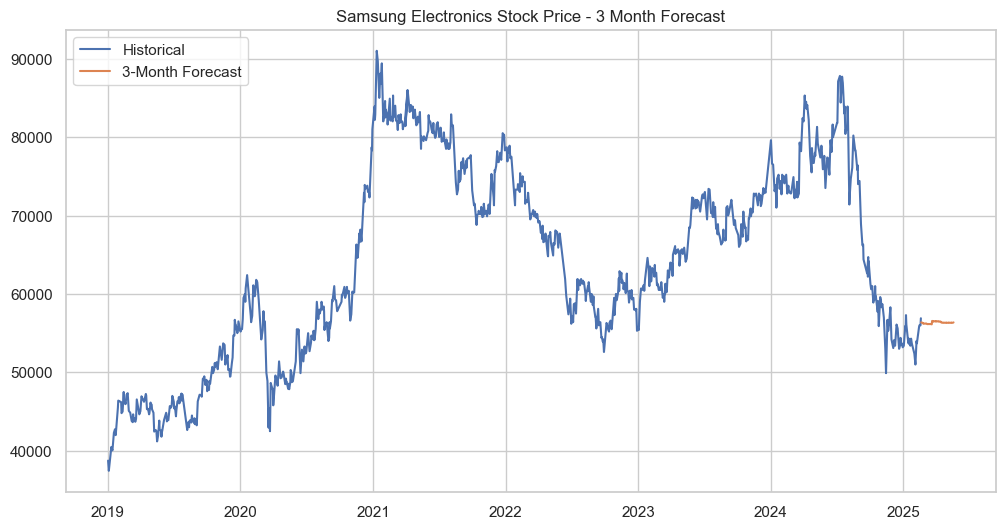

In [492]:
plt.figure(figsize=(12, 6))
plt.plot(data_xg['ds'], data_xg['y'], label='Historical')
plt.plot(future_dates, future_pred, label='3-Month Forecast')
plt.legend()
plt.title('Samsung Electronics Stock Price - 3 Month Forecast')
plt.show()

In [493]:
# Create forecast dataframe
forecast_result = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Price': future_pred
})
print(forecast_result.head(10))

        Date  Forecasted_Price
0 2025-02-19      56370.949219
1 2025-02-20      56364.250000
2 2025-02-21      56332.742188
3 2025-02-22      56332.742188
4 2025-02-23      56294.824219
5 2025-02-24      56238.929688
6 2025-02-25      56266.460938
7 2025-02-26      56218.726562
8 2025-02-27      56212.027344
9 2025-02-28      56212.027344


-------------------

## **4.2. XGBoost Model**

In [505]:
def create_features(ss_pd, target_column, lag_periods=5):
    """Create time series features based on lagged values."""
    
    # Add lag features
    for lag in range(1, lag_periods + 1):
        ss_pd[f'lag_{lag}'] = ss_pd[target_column].shift(lag)
    
    # Add rolling mean features
    for window in [7, 14, 30]:
        ss_pd[f'rolling_mean_{window}'] = ss_pd[target_column].rolling(window=window).mean()
    
    # Add rolling std features
    for window in [7, 14, 30]:
        ss_pd[f'rolling_std_{window}'] = ss_pd[target_column].rolling(window=window).std()
    
    # Add date-based features
    ss_pd['day_of_week'] = ss_pd.index.dayofweek
    ss_pd['month'] = ss_pd.index.month
    ss_pd['quarter'] = ss_pd.index.quarter
    
    # Add price-based features
    if 'Open' in ss_pd.columns and 'High' in ss_pd.columns and 'Low' in ss_pd.columns:
        ss_pd['price_range'] = ss_pd['High'] - ss_pd['Low']
        ss_pd['daily_return'] = ss_pd[target_column].pct_change()
        ss_pd['volatility'] = ss_pd['daily_return'].rolling(window=7).std()
    
    # Drop rows with NaN values resulting from lag/rolling operations
    ss_pd = ss_pd.dropna()
    
    return ss_pd
# Create features
data_features = create_features(ss_pd, 'Close')
print(f"Created {len(data_features.columns) - len(ss_pd.columns)} new features")
print("Feature list:", data_features.columns.tolist())

Created 0 new features
Feature list: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1M_Return', '3M_Return', '6M_Return', 'Sentiment', 'EMA_Fast', 'EMA_Slow', 'MACD', 'Signal_Line', 'MACD_Histogram', 'MA_50', 'MA_200', 'Signal', 'RSI', 'Close_diff', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30', 'rolling_std_7', 'rolling_std_14', 'rolling_std_30', 'day_of_week', 'month', 'quarter', 'price_range', 'daily_return', 'volatility']


In [506]:
# Prepare data for modeling
X = data_features.drop('Close', axis=1)
y = data_features['Close']

In [507]:
# Scale the features
# First convert non-numeric columns to numeric
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X_numeric = X[numeric_columns]

# Scale only numeric features
scaler = MinMaxScaler()
X_scaled_numeric = scaler.fit_transform(X_numeric)
X_scaled = pd.DataFrame(X_scaled_numeric, columns=numeric_columns, index=X.index)

# Add back any categorical columns if needed
categorical_columns = X.select_dtypes(exclude=['float64', 'int64']).columns
if len(categorical_columns) > 0:
    X_scaled = pd.concat([X_scaled, X[categorical_columns]], axis=1)

In [508]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled.iloc[:train_size], X_scaled.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training data: {X_train.shape[0]} samples")
print(f"Testing data: {X_test.shape[0]} samples")

Training data: 1044 samples
Testing data: 262 samples


In [509]:
# Feature importance analysis using XGBoost
print("\nTraining initial XGBoost model for feature importance analysis...")
# Convert any non-numeric columns to numeric
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64'])

model_initial = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_initial.fit(X_train_numeric, y_train)


Training initial XGBoost model for feature importance analysis...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

<Figure size 1200x800 with 0 Axes>

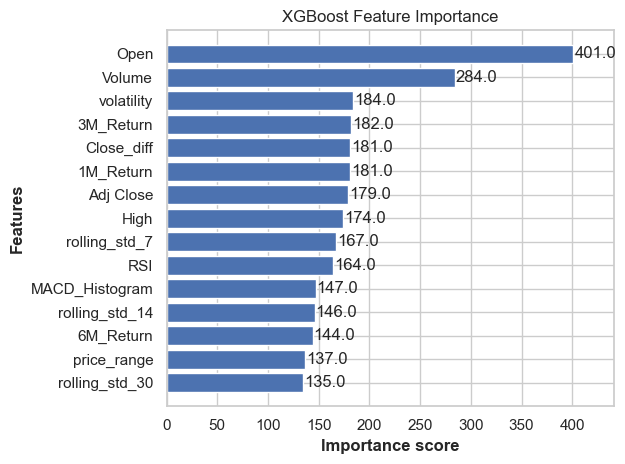

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model_initial, max_num_features=15, height=0.8)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [511]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [512]:
# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [513]:
# Create and fit GridSearchCV
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

In [527]:
def fix_grid_search_option2(X_train, y_train, grid_search):
    """
    Fix grid search by providing a validation set for early stopping
    
    This approach lets you keep early_stopping_rounds by providing a validation set
    """
    # Use numeric features only
    X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
    
    # Split training data to create a validation set
    from sklearn.model_selection import train_test_split
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train_numeric, y_train, test_size=0.2, random_state=42
    )
    
    # Fit grid search with early stopping using validation set
    grid_search.fit(
        X_train_split, 
        y_train_split,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [ ]:
try:
    # Use numeric features only like in the initial model
    X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
    
    # Reduce parameter grid size for faster execution
    reduced_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1, 0.01],
        'subsample': [0.8, 1.0, 0.9],
        'colsample_bytree': [0.8, 1.0, 0.9]
    }
    
    # Update grid search with reduced parameters
    grid_search.param_grid = reduced_param_grid
    
    # Explicitly disable early stopping by creating a new estimator without early_stopping_rounds
    grid_search.estimator = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    grid_search.fit(X_train_numeric, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
except Exception as e:
    print(f"Grid search failed: {e}")
    print("Using default XGBoost model instead")
    X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
    # Use lighter default model
    best_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,
                                 max_depth=3, learning_rate=0.1, random_state=42)
    best_model.fit(X_train_numeric, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 

In [515]:
# Make predictions on test set using numeric features only
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64'])
y_pred = best_model.predict(X_test_numeric)


# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\nModel Performance Metrics on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



Model Performance Metrics on Test Data:
Mean Squared Error (MSE): 1282212.18
Root Mean Squared Error (RMSE): 1132.35
Mean Absolute Error (MAE): 770.24
R² Score: 0.9896
Mean Absolute Percentage Error (MAPE): 1.05%


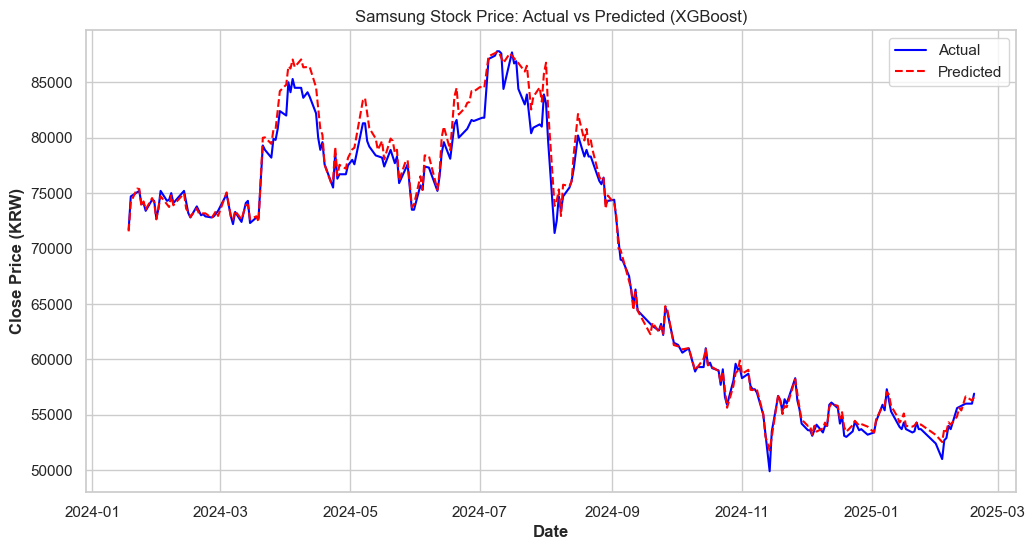

In [516]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Samsung Stock Price: Actual vs Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.show()


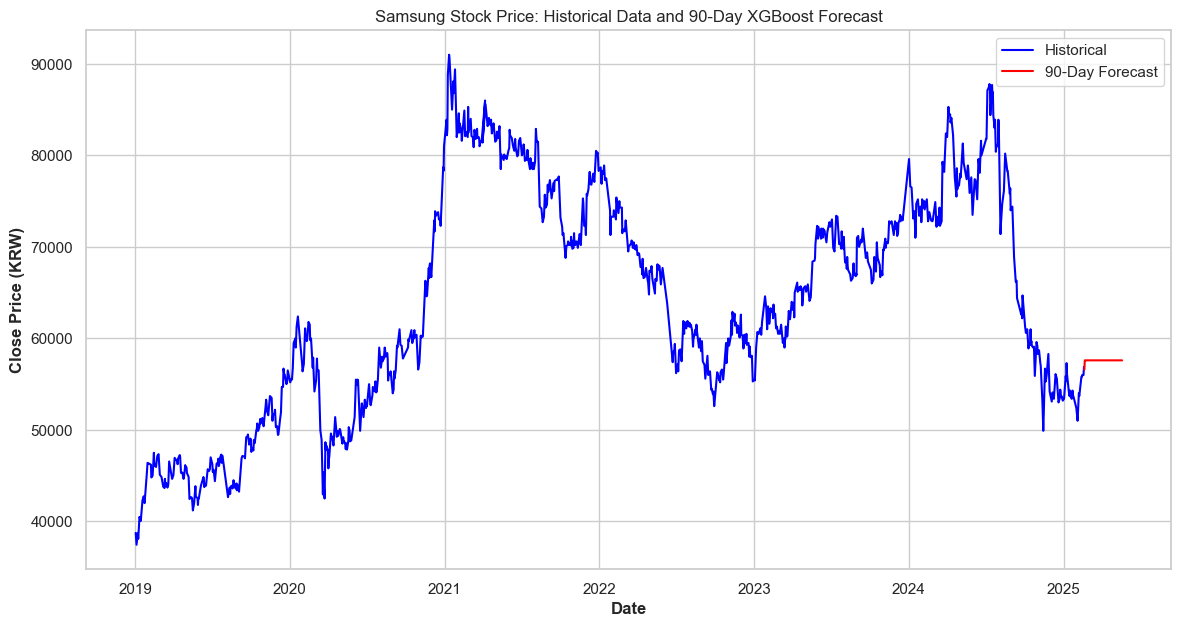

In [517]:
# Get the last date and close price
last_date = ss_pd.index[-1]
last_close = ss_pd['Close'].iloc[-1]

# Create future dates (90 days)
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=90)

# Initialize predictions list with the last known price
predictions = [last_close]

# Create a dataframe to store predictions
future_df = pd.DataFrame(index=future_dates)
future_df['Predicted_Close'] = np.nan

# Get the last row of training data to use as initial features
last_features = X_test_numeric.iloc[-1:].copy()

# Remove 'Close' column if it exists to match training data
if 'Close' in last_features.columns:
    last_features = last_features.drop('Close', axis=1)

# For each future date
for i in range(90):
    # Make prediction using all features from last timestep
    next_pred = best_model.predict(last_features)[0]
    predictions.append(next_pred)
    
    # Store in dataframe
    future_df['Predicted_Close'].iloc[i] = next_pred
    
    # Update features for next prediction
    # Here we need to update relevant features without using Close directly
    # For example, we could update price-based features using the predicted value
    if 'Adj Close' in last_features.columns:
        last_features['Adj Close'] = next_pred

# Plot historical data and future predictions
plt.figure(figsize=(14, 7))
plt.plot(ss_pd.index, ss_pd['Close'], label='Historical', color='blue')
plt.plot(future_df.index, future_df['Predicted_Close'], 
         label='90-Day Forecast', color='red')
plt.title('Samsung Stock Price: Historical Data and 90-Day XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.show()
